In [4]:
# Example-7-MGP-BS-Pricing
# Author: Matthew Dixon
# Version: 1.0 (28.4.2020)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X running Python 3.6.9 with the following packages:
# scikit-learn=0.22.1, numpy=1.18.1, matplotlib=3.1.3, gpytorch=0.1.0, torch=1.0, scipy
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Dixon M.F., Halperin I. and P. Bilokon, Machine Learning in Finance: From Theory to Practice, Springer Graduate Textbook Series, 2020.

# Overview
The purpose of this notebook is to demonstrate the fitting of a multi-response Gaussian Process Regression model (GP) to the prices of two options. In this notebook, the prices of a call and put are generated from the Black-Scholes model.  The notebook begins by building a multi-GP model, and then evaluates the error.

Finally the notebook studies the posterior covariance term which is uniquely available in the multi-GP model. See Section 6 for further details.

In [2]:
import math
import torch
import gpytorch
import numpy as np
from scipy import *
from BlackScholes import *
from matplotlib import pyplot as plt
from scipy import stats  

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Black-Scholes Model

In [2]:
r = 0.0  # risk-free rate
S= 100      # Underlying spot
KC = 110    # Call strike
KP = 90     # Put strike
sigma = 0.3 # implied volatility
T = 2.0     # Time to maturity

In [3]:
# define the call and put prices using the BS model
call = lambda x: bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[0]
put = lambda x: bsformula(-1, lb+(ub-lb)*x, KP, r, T, sigma, 0)[0]

In [17]:
lb = 0.001             # lower bound on domain
ub = 300               # upper bound on domain
training_number = 50   # Number of training samples
testing_number =  100  # Number of testing samples

train_x = torch.linspace(0, 1.0, training_number)
train_y1 = torch.FloatTensor(call(np.array(train_x)))
train_y2 = torch.FloatTensor(put(np.array(train_x)))

#Create a train_y which interleaves the two
train_y = torch.stack([train_y1, train_y2], -1)

## Define multi-reponse GP class

In [18]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        
        self.covar_module = gpytorch.kernels.MultitaskKernel(gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5)), num_tasks=2, rank=1
        )
              
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


In [19]:
test_x = torch.linspace(0, 1.0, testing_number)
test_y1 = torch.FloatTensor(call(np.array(test_x)))
test_y2 = torch.FloatTensor(put(np.array(test_x)))
test_y = torch.stack([test_y1, test_y2], -1)

# Fit the multi-GP model

In [21]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 300
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f lengthscale: %.3f noise: %.3f' % (i + 1, n_iter, loss.item(), model.covar_module.data_covar_module.base_kernel.lengthscale, likelihood.noise))
    
    optimizer.step()

Iter 1/300 - Loss: 13345.648 lengthscale: 0.693 noise: 0.693
Iter 2/300 - Loss: 11176.000 lengthscale: 0.644 noise: 0.744
Iter 3/300 - Loss: 9369.323 lengthscale: 0.599 noise: 0.797
Iter 4/300 - Loss: 7895.261 lengthscale: 0.556 noise: 0.850
Iter 5/300 - Loss: 6709.302 lengthscale: 0.516 noise: 0.904
Iter 6/300 - Loss: 5760.086 lengthscale: 0.481 noise: 0.957
Iter 7/300 - Loss: 4999.820 lengthscale: 0.448 noise: 1.009
Iter 8/300 - Loss: 4384.673 lengthscale: 0.419 noise: 1.059
Iter 9/300 - Loss: 3882.839 lengthscale: 0.394 noise: 1.109
Iter 10/300 - Loss: 3467.536 lengthscale: 0.371 noise: 1.156
Iter 11/300 - Loss: 3119.624 lengthscale: 0.351 noise: 1.202
Iter 12/300 - Loss: 2824.473 lengthscale: 0.333 noise: 1.246
Iter 13/300 - Loss: 2571.085 lengthscale: 0.318 noise: 1.288
Iter 14/300 - Loss: 2351.561 lengthscale: 0.304 noise: 1.328
Iter 15/300 - Loss: 2160.409 lengthscale: 0.292 noise: 1.367
Iter 16/300 - Loss: 1991.983 lengthscale: 0.281 noise: 1.403
Iter 17/300 - Loss: 1843.273 le

Iter 139/300 - Loss: 315.278 lengthscale: 0.219 noise: 2.003
Iter 140/300 - Loss: 313.001 lengthscale: 0.219 noise: 2.003
Iter 141/300 - Loss: 310.985 lengthscale: 0.219 noise: 2.003
Iter 142/300 - Loss: 310.051 lengthscale: 0.219 noise: 2.003
Iter 143/300 - Loss: 309.568 lengthscale: 0.219 noise: 2.003
Iter 144/300 - Loss: 307.249 lengthscale: 0.219 noise: 2.003
Iter 145/300 - Loss: 308.424 lengthscale: 0.219 noise: 2.003
Iter 146/300 - Loss: 306.477 lengthscale: 0.218 noise: 2.002
Iter 147/300 - Loss: 304.543 lengthscale: 0.218 noise: 2.002
Iter 148/300 - Loss: 304.491 lengthscale: 0.218 noise: 2.002
Iter 149/300 - Loss: 302.469 lengthscale: 0.218 noise: 2.002
Iter 150/300 - Loss: 302.629 lengthscale: 0.218 noise: 2.002
Iter 151/300 - Loss: 301.155 lengthscale: 0.218 noise: 2.002
Iter 152/300 - Loss: 299.460 lengthscale: 0.218 noise: 2.001
Iter 153/300 - Loss: 298.979 lengthscale: 0.218 noise: 2.001
Iter 154/300 - Loss: 298.037 lengthscale: 0.218 noise: 2.001
Iter 155/300 - Loss: 296

Iter 274/300 - Loss: 223.161 lengthscale: 0.209 noise: 1.885
Iter 275/300 - Loss: 222.477 lengthscale: 0.209 noise: 1.884
Iter 276/300 - Loss: 221.840 lengthscale: 0.209 noise: 1.882
Iter 277/300 - Loss: 225.416 lengthscale: 0.209 noise: 1.880
Iter 278/300 - Loss: 222.074 lengthscale: 0.209 noise: 1.879
Iter 279/300 - Loss: 221.752 lengthscale: 0.209 noise: 1.877
Iter 280/300 - Loss: 220.667 lengthscale: 0.209 noise: 1.876
Iter 281/300 - Loss: 219.214 lengthscale: 0.209 noise: 1.874
Iter 282/300 - Loss: 220.591 lengthscale: 0.209 noise: 1.872
Iter 283/300 - Loss: 218.572 lengthscale: 0.209 noise: 1.871
Iter 284/300 - Loss: 220.025 lengthscale: 0.209 noise: 1.869
Iter 285/300 - Loss: 219.337 lengthscale: 0.209 noise: 1.867
Iter 286/300 - Loss: 217.826 lengthscale: 0.209 noise: 1.866
Iter 287/300 - Loss: 218.546 lengthscale: 0.209 noise: 1.864
Iter 288/300 - Loss: 217.763 lengthscale: 0.209 noise: 1.862
Iter 289/300 - Loss: 216.194 lengthscale: 0.209 noise: 1.861
Iter 290/300 - Loss: 217

In [23]:
# Make predictions
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    y_hat= likelihood(model(test_x))
lower, upper = y_hat.confidence_region()

In [25]:
# Print fitted parameters
a = model.covar_module.task_covar_module.covar_factor.clone().detach()
v = model.covar_module.task_covar_module.var.clone().detach()
Omega = np.outer(a,a) + np.diag(v)
#lengthscale=model.covar_module.data_covar_module.lengthscale
lengthscale = model.covar_module.data_covar_module.base_kernel.lengthscale
sigma_2_n = likelihood.noise
nu = model.covar_module.data_covar_module.base_kernel.nu
print(lengthscale, sigma_2_n, nu, Omega)

tensor([[[0.2084]]], grad_fn=<ClampBackward>) tensor([[1.8397]], grad_fn=<SoftplusBackward>) 2.5 [[36.977943  -1.1028435]
 [-1.1028435  3.068603 ]]


Text(0,0.5,'$\\pi$')

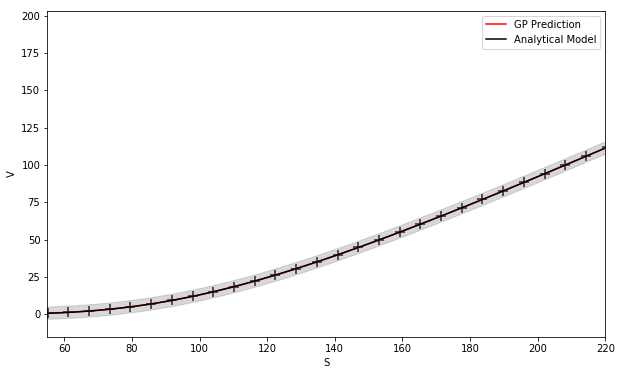

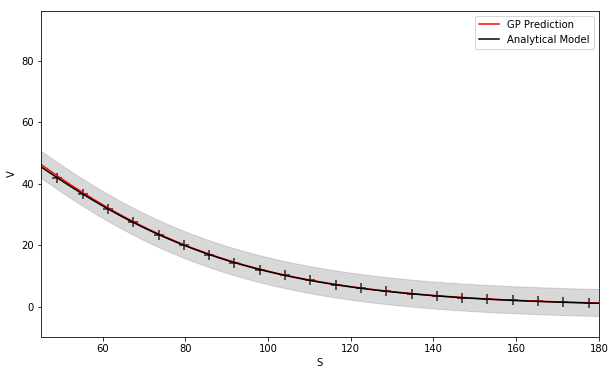

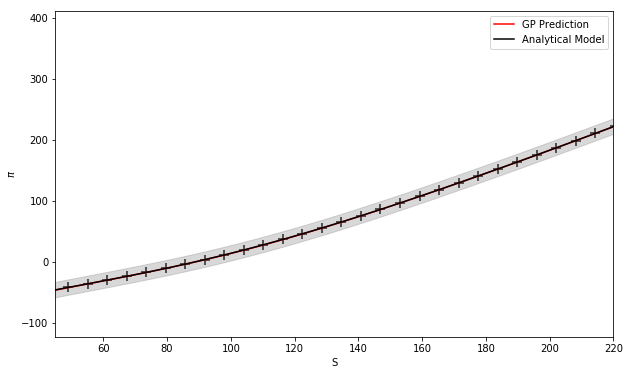

In [26]:
# predictionn plot with var band 
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(y_hat.mean[:,0]), color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(test_y[:,0]), color = 'black', label = 'Analytical Model')
plt.scatter(lb+(ub-lb)*train_x, train_y[:,0], color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*np.array(test_x.flatten()), lower[:,0].detach().numpy(), upper[:,0].detach().numpy(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([KC/2.0,2*KC])
plt.xlabel('S')
plt.ylabel('V')


plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(y_hat.mean[:,1]), color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(test_y[:,1]), color = 'black', label = 'Analytical Model')
plt.scatter(lb+(ub-lb)*train_x, train_y[:,1], color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*np.array(test_x.flatten()), lower[:,1].detach().numpy(), upper[:,1].detach().numpy(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([KP/2.0,2*KP])
plt.xlabel('S')
plt.ylabel('V')


plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), 2.0*np.array(y_hat.mean[:,0])- np.array(y_hat.mean[:,1]), color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), 2.0*np.array(test_y[:,0])-np.array(test_y[:,1]) , color = 'black', label = 'Analytical Model')
plt.scatter(lb+(ub-lb)*train_x, 2*train_y[:,0]-train_y[:,1], color = 'black', marker = '+', s = 100) 

plt.fill_between(lb+(ub-lb)*np.array(test_x.flatten()), 2.0*lower[:,0].detach().numpy()-upper[:,1].detach().numpy() , 2.0*upper[:,0].detach().numpy()-lower[:,1].detach().numpy(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([KP/2.0,2*KC])
plt.xlabel('S')
plt.ylabel('$\pi$')

## Evaluate the covariance of the posterior

In [27]:
# covariance of posterior
var_1=np.diag(np.array(y_hat.covariance_matrix.detach().numpy()),0)[0:199:2]
var_2=np.diag(np.array(y_hat.covariance_matrix.detach().numpy()),0)[1:199:2]
covar_12=np.diag(np.array(y_hat.covariance_matrix.detach().numpy()),1)[0:199:2]

/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:437: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


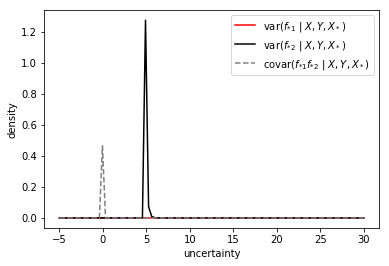

In [28]:
lnspc = np.linspace(-5.0, 30, 100)

ab,bb,cb,db = stats.beta.fit(var_1)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='var($f_{*1}$ $\|$ $X,Y,X_*$)', color='r')

ab,bb,cb,db = stats.beta.fit(var_2)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='var($f_{*2}$ $\|$ $X,Y,X_*$)', color='k')

ab,bb,cb,db = stats.beta.fit(covar_12)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label='covar($f_{*1}f_{*2}$ $\|$ $X,Y,X_*$)', color="grey", linestyle='--')

plt.xlabel('uncertainty')
plt.ylabel('density')
plt.legend()
plt.show()